In [2]:
from os.path import join,expanduser
import sys
import cmocean as cmo
# identify user's home directory
user_home_dir = expanduser('~')
# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import botocore
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
from matplotlib import colors as mcolors
from matplotlib.cm import ScalarMappable
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr
# Use this for the netcdf files stored on an s3 bucket


In [3]:
# 1. Define data path and get list of monthly files
directory  = Path('/home/jovyan/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_TEMPERATURE_SALINITY')
file_paths = np.sort(list(directory.glob('*.nc')))  # make sure only .nc files
# 2. Initialize lists for temperature and time


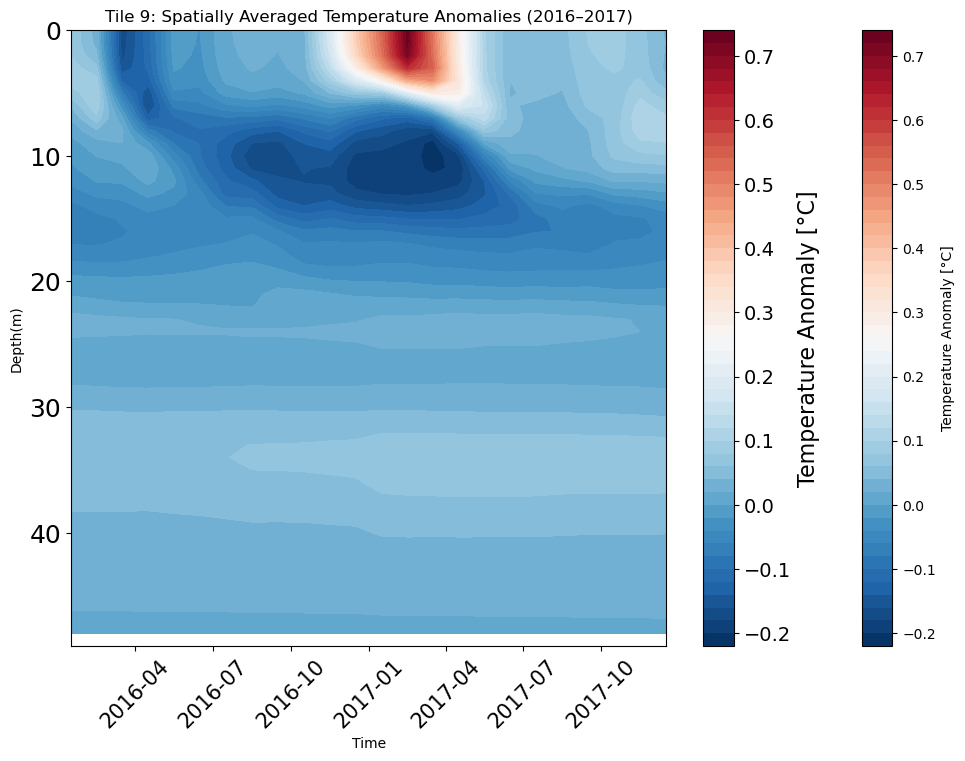

In [4]:
##2. extract the temperature from a specific tile 
temps = [];times = []
# 3. Loop through each file and extract tile 9 temperature
for file_path in file_paths:
    ds   = xr.open_dataset(file_path)
    # ECCO format: dimensions are (tile, k, j, i)
    temp = ds['THETA'].isel(tile=9)  # (k, j, i)
    time = ds.time
    temps.append(temp)
    times.append(time)

# 4. Combine into one xarray DataArray
temps_all = xr.concat(temps, dim='time')
temps_all['time'] = xr.concat(times, dim='time')
# 5. Compute monthly climatology (1992–2015, or full range)
clim      = temps_all.groupby('time.month').mean('time')
# 6. Compute anomalies
anomalies = temps_all.groupby('time.month') - clim
# 7. Spatial average (mean over j and i dims)
tile9_spatial_avg = anomalies.mean(dim=('j', 'i'))
# 8. Select time range 2016–2017
sel       = tile9_spatial_avg.sel(time=slice('2016-01', '2017-12'))
# 9. ---------Plot: depth vs time-------------------
plt.figure(figsize=(12, 8))
depth     = sel.k  # ECCO uses vertical index k
time      = sel.time
ca = plt.contourf(time, depth, sel.T, levels=50, cmap='RdBu_r')
plt.gca().tick_params(axis="y", which='major', labelsize=18)
plt.gca().tick_params(axis="x", which='major', labelsize=15,rotation=45)
plt.gca().invert_yaxis()
plt.title("Tile 9: Spatially Averaged Temperature Anomalies (2016–2017)")
plt.xlabel("Time")
plt.ylabel("Depth(m)")
plt.colorbar(label="Temperature Anomaly [°C]")
# Larger colorbar label and tick labels
cb = plt.colorbar(ca)
cb.set_label("Temperature Anomaly [°C]", fontsize=16)
cb.ax.tick_params(labelsize=14)  # Tick label size
plt.savefig(f'/home/jovyan/efs_ecco/sdarma/FIGURES/TEMP_ANOM_SPATIALLY_AVERAGED_TILE9.png')